Using **FASTSRegressor** to forecast the number of Air Passengers.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from IPython.display import HTML, display

import datetime
from time import time

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 12, 6

from fasts import estimators as es
from fasts import valid as vd
from fasts import utils as us
from fasts.datasets import load_data

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
passengers = load_data("passengers.csv")
display(passengers)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, Length: 144, dtype: int64

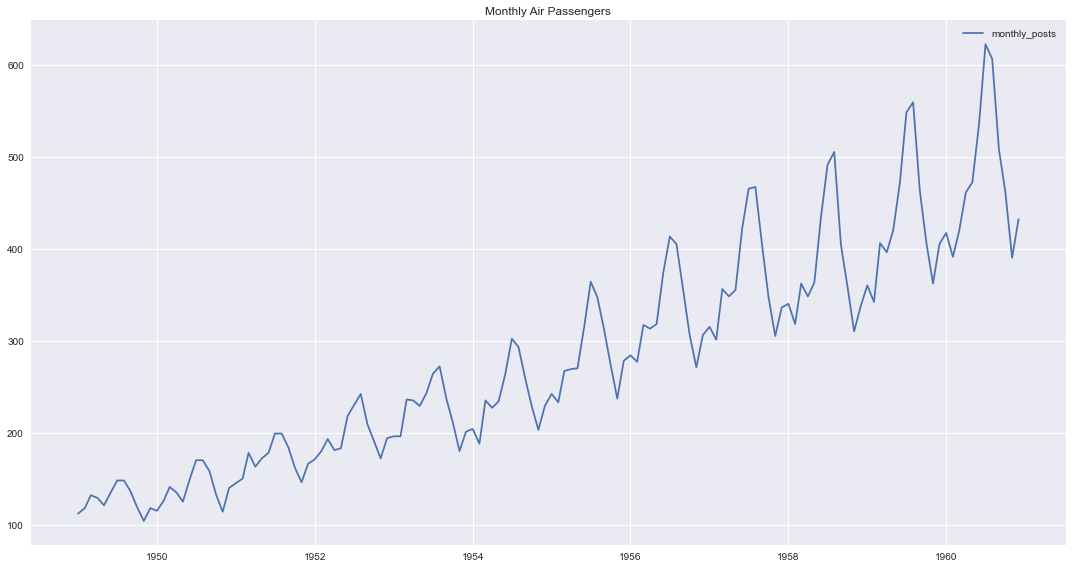

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(passengers, label="monthly_posts")
plt.title("Monthly Air Passengers")
plt.legend()    
plt.tight_layout()

Likely, there's a weekly component.

In [4]:
n_jobs=-1
# 5, 10, 15, 25, 50, 75
n_iter=25
# forecasting horizon: 
# monthly: 12 (one year), 24 (two years)
fh=24
test_size=fh
n_lags=18

In [5]:
passengers.min()

104

## Power Transformations

### PowerTransform

In [6]:
# perform a box-cox transform of the dataset
scaler = MinMaxScaler(feature_range=(1, 10))
# method='box-cox'
# power = PowerTransformer(standardize=False, method='box-cox')
# pipeline = Pipeline(steps=[('s', scaler),('p', power)])
power = PowerTransformer(method='box-cox')

In [7]:
passengers_y_scale_bc = power.fit_transform(passengers.values.reshape(-1, 1)).ravel()
passengers_y_scale_bc[:10]

array([-1.79872086, -1.69309768, -1.46339556, -1.51080691, -1.64199225,
       -1.41689353, -1.22503242, -1.22503242, -1.40158845, -1.67594076])

In [8]:
len(passengers_y_scale_bc)

144

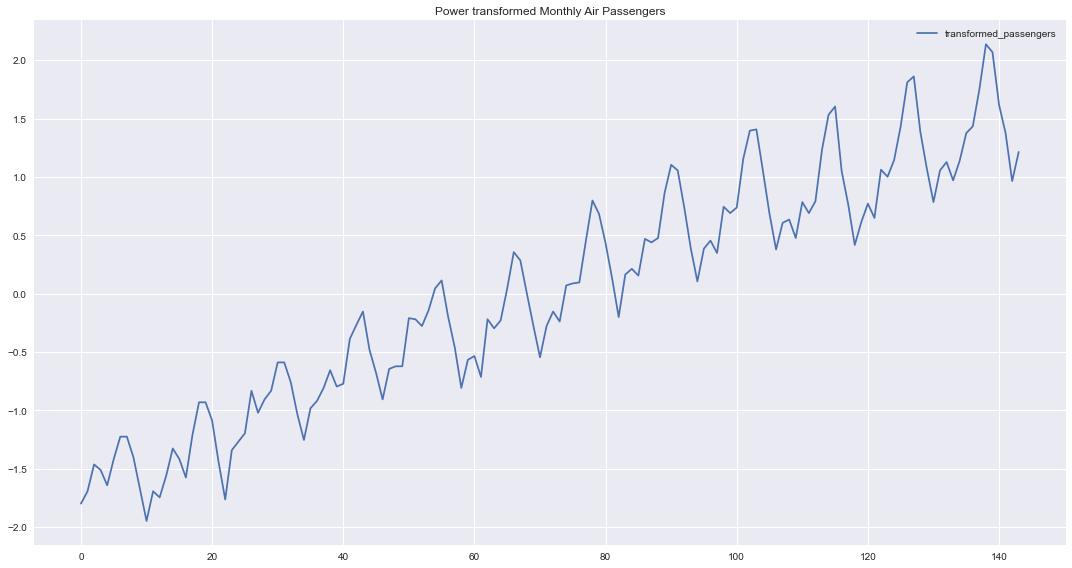

In [9]:
plt.figure(figsize=(15, 8))
plt.plot(passengers_y_scale_bc, label="transformed_passengers")
plt.title("Power transformed Monthly Air Passengers")
plt.legend()    
plt.tight_layout()

In [10]:
X, y = us.embed_to_X_y(
    pd.Series(passengers_y_scale_bc), 
    n_lags=n_lags, name='passengers')

In [11]:
y.min()

-1.7629885794234066

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, shuffle=False)

In [13]:
display(X_train)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18
0,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396,-1.693098,-1.798721
1,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396,-1.693098
2,-0.930842,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396
3,-1.086990,-0.930842,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807
4,-1.447796,-1.086990,-0.930842,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1.532152,1.230997,0.790956,0.690011,0.784338,0.476468,0.634649,0.606551,0.378559,0.683151,1.049777,1.406868,1.396182,1.156386,0.737571,0.690011,0.744300,0.347718
98,1.602844,1.532152,1.230997,0.790956,0.690011,0.784338,0.476468,0.634649,0.606551,0.378559,0.683151,1.049777,1.406868,1.396182,1.156386,0.737571,0.690011,0.744300
99,1.049777,1.602844,1.532152,1.230997,0.790956,0.690011,0.784338,0.476468,0.634649,0.606551,0.378559,0.683151,1.049777,1.406868,1.396182,1.156386,0.737571,0.690011
100,0.764390,1.049777,1.602844,1.532152,1.230997,0.790956,0.690011,0.784338,0.476468,0.634649,0.606551,0.378559,0.683151,1.049777,1.406868,1.396182,1.156386,0.737571


In [14]:
y_train.min()

-1.7629885794234066

In [15]:
fasts = es.FASTSRegressor(
    # lasso_alpha=0.01,
    quantile_reg=True,
    )
fasts_params = vd.fasts_param_distros

In [16]:
fasts_params

{'lasso_alpha': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1fa6a08>,
 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1faf188>,
 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1faf0c8>,
 'subsample': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1fa6408>,
 'max_features': [None, 0.75, 0.5, 'log2'],
 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1fafdc8>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x21da1fafe88>}

In [17]:
display(X_train.head(3))

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18
0,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396,-1.693098,-1.798721
1,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396,-1.693098
2,-0.930842,-0.930842,-1.210877,-1.575505,-1.416894,-1.326471,-1.559167,-1.745322,-1.693098,-1.947319,-1.675941,-1.401588,-1.225032,-1.225032,-1.416894,-1.641992,-1.510807,-1.463396


In [18]:
# %time fasts.fit(X_train, y_train)

In [19]:
print("=== TS Randomized Search CV...")
print()

rscv = vd.TSRandomizedSearchCV(
    estimator=fasts, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

failed = 0
try:
    t0 = time()
    rscv.fit(X_train, y_train)
    t1 = time()
except ValueError as ve:
    failed = 1
    print("ValueError:", ve)
    # adjust learning_rate distro for spanning little numbers?
    fasts_params["lasso_alpha"] = vd.loguniform(1e-3, 1e-2)
except Exception as e:
    failed = 1
    print("Mysterious Exception:", e)

=== TS Randomized Search CV...

ValueError: Found array with 0 feature(s).


In [20]:
if failed:
    try:
        t0 = time()
        rscv.fit(X_train, y_train)
        t1 = time()
    except ValueError as ve:
        print("ValueError:", ve)
    except Exception as e:
        print("Mysterious Exception:", e)

Best validation rmse score overall: 0.212 ± 0.043
Refitting best estimator...
X cols 18
X_sel_ cols 9
with quantile regression.
self.gbr_fitted_.n_features = 9


Full time of Search: 46.61 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[0.6136018573407688, 0.41662966539593155, 0.7643899504765508, 1.049776585666388, 1.602844109814903, 1.5321520795575625, 1.2309972137487843, 0.7909557840811434, 0.6900112765495423, 0.7843377969229831, 0.4764679557481491, 0.6346490880800354, 0.6065506356408661, 0.3785592144973318, 0.6831506709788487, 1.049776585666388, 1.406867981426004, 1.3961817562938215]
length of first Lasso test window: 18
[-0.052372090400771065, -0.14463219747930206, -0.04197319468614502, -0.2189243439864117, 0.038936232857006425, -0.00035375509455670695, -0.018755387952265945, -0.09389569786533514, -0.18383757327399808]
length of first GradBoost test window (residuals): 9

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 18
[-0.052372090400771065, -0.144632197

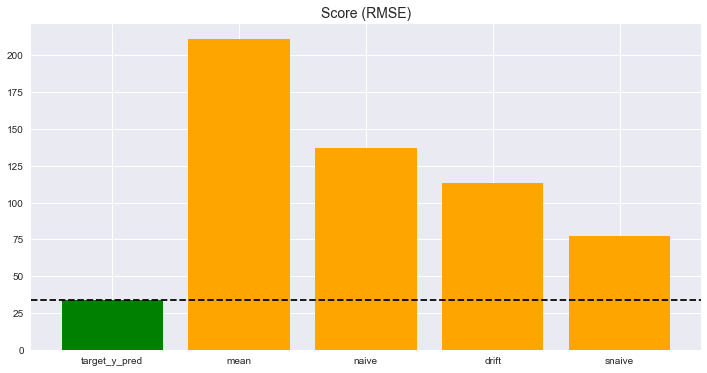

In [21]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts = rscv.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores, spreds, tgt_preds = best_fasts.compare_to_baselines(
    y_train, 
    y_test, 
    season=12,
    fh=fh, 
    bar_plot=True,
    bck_transformer=power
)

In [22]:
us.mean_absolute_percentage_error(
    passengers.values[-fh:],
    tgt_preds[tgt_preds > 0].fillna(0)["y_pred"])

6.387342019533042

In [23]:
tgt_preds

,y_pred,low_80,up_80,low_95,up_95
0,356.393655,276.904941,454.550477,241.210901,515.465652
1,346.419546,276.366749,431.065946,244.340431,482.790675
2,379.809984,305.124362,469.537777,270.818607,524.142861
3,379.219562,295.236559,482.754295,257.472471,546.931385
4,395.364099,324.873019,478.488705,291.996646,528.402342
5,462.083065,364.074241,581.729511,319.644105,655.378261
6,522.170230,433.105891,626.386346,391.304468,688.615733
7,533.710857,442.008441,641.148435,399.012686,705.359570
8,445.481071,355.321879,554.441219,314.109268,621.031490
9,386.404001,311.067621,476.758707,276.414279,531.677869


In [24]:
spreds

,mean,naive,drift,snaive
0,254.854218,337.0,336.488870,340.0
1,254.854218,337.0,339.335385,318.0
2,254.854218,337.0,340.766318,362.0
3,254.854218,337.0,343.643613,348.0
4,254.854218,337.0,345.090005,363.0
5,254.854218,337.0,347.998354,435.0
6,254.854218,337.0,350.927561,491.0
7,254.854218,337.0,352.400024,505.0
8,254.854218,337.0,355.360747,404.0
9,254.854218,337.0,356.849039,359.0


In [25]:
passengers[-fh:]

Month
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
1959-09-01    463
1959-10-01    407
1959-11-01    362
1959-12-01    405
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: Passengers, dtype: int64


full_time_series_df
            orig_scale_posts   forecasts  y_test        mean  naive  \
Month                                                                 
1960-08-01               NaN  562.942124   606.0  254.854218  337.0   
1960-09-01               NaN  484.085885   508.0  254.854218  337.0   
1960-10-01               NaN  415.729098   461.0  254.854218  337.0   
1960-11-01               NaN  370.568005   390.0  254.854218  337.0   
1960-12-01               NaN  377.385454   432.0  254.854218  337.0   

                 drift  snaive      low_80       up_80      low_95       up_95  
Month                                                                           
1960-08-01  379.819091   505.0  469.120808  672.298320  424.947487  737.413459  
1960-09-01  382.974857   404.0  391.558744  594.624856  348.861228  661.624057  
1960-10-01  384.561099   359.0  330.998392  518.279684  292.314105  581.018780  
1960-11-01  387.750381   310.0  304.433176  448.569339  273.592937  495.4125

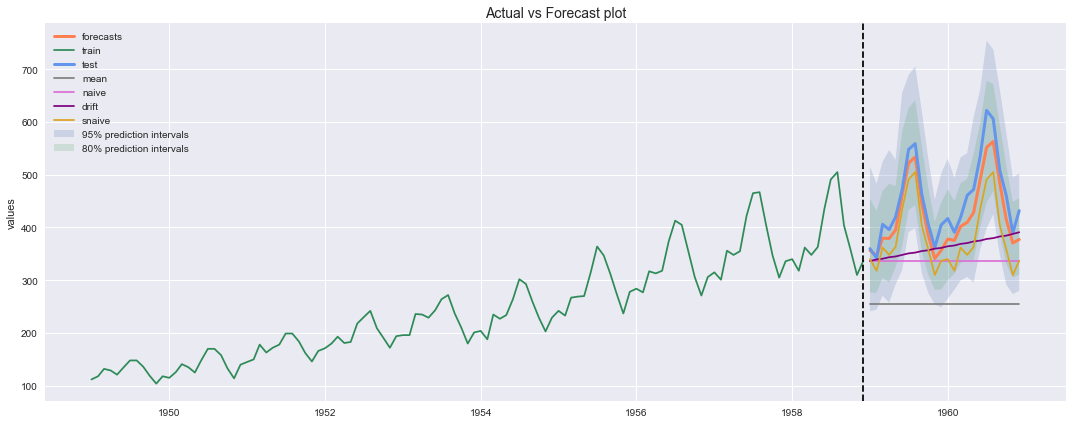

In [26]:
us.plot_forecasts(
    passengers[:-fh],
    tgt_preds[tgt_preds > 0].fillna(0),
    passengers.index, 
    y_test=passengers[-fh:],
    simple_preds=spreds,
    return_pred_int=True)

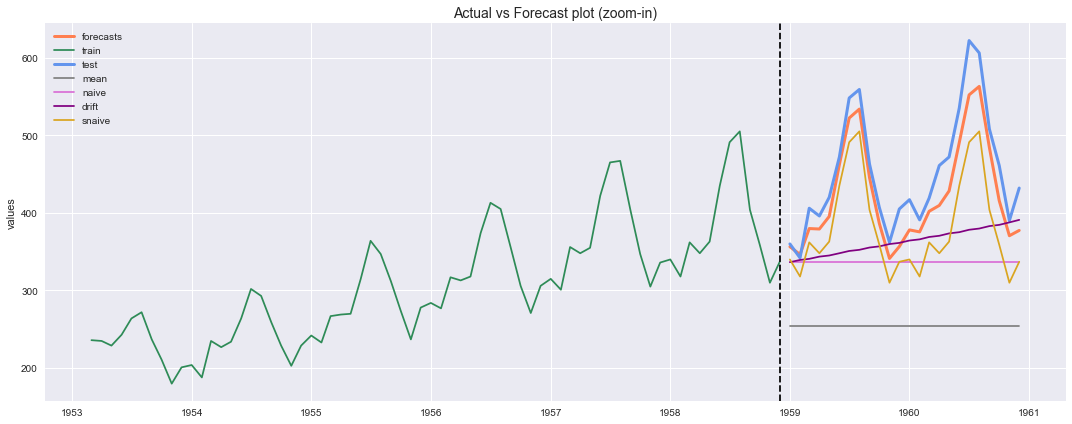

In [27]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds[tgt_preds > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    simple_preds=spreds,
    title='Actual vs Forecast plot (zoom-in)')

Model **underestimates** future nr. of passengers.

In [28]:
fasts.get_params()

{'criterion': 'friedman_mse',
 'lasso_alpha': 0.002854351186389649,
 'learning_rate': 0.28191887999735527,
 'loss': 'quantile',
 'max_depth': 4,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 84,
 'quantile_reg': True,
 'subsample': 0.8759307963430452}

### Inference- forecasts

Train on full data set, predict the future w/o test comparison.

In [29]:
# once and for all
full_series_index = pd.date_range(start=passengers.index[0], periods=(len(passengers) + fh))
print(full_series_index)

DatetimeIndex(['1949-01-01', '1949-01-02', '1949-01-03', '1949-01-04',
               '1949-01-05', '1949-01-06', '1949-01-07', '1949-01-08',
               '1949-01-09', '1949-01-10',
               ...
               '1949-06-08', '1949-06-09', '1949-06-10', '1949-06-11',
               '1949-06-12', '1949-06-13', '1949-06-14', '1949-06-15',
               '1949-06-16', '1949-06-17'],
              dtype='datetime64[ns]', length=168, freq='D')


In [30]:
print("=== Fit best model upon full X, y (using best parameters from rdn search)...")

t0 = time()
best_fasts.fit(X, y)
t1 = time()

=== Fit best model upon full X, y (using best parameters from rdn search)...
X cols 18
X_sel_ cols 6
with quantile regression.
self.gbr_fitted_.n_features = 6


In [31]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full, tgt_fcs_full = best_fasts.compare_to_baselines(
    y, 
    season=12, 
    fh=fh,
    bck_transformer=power
)

Time of fitting: 1.06 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[1.213949513713541, 0.9640232430098433, 1.3746912991739657, 1.6177748034411679, 2.0684924107272877, 2.136082221759653, 1.74887379504282, 1.4334139384379636, 1.3746912991739657, 1.1388900802436488, 0.970234734902744, 1.1271668853033392, 1.055804440668208, 0.7843377969229831, 1.0678222068715435, 1.38545630035075, 1.8607560448714073, 1.8099952940341686]
length of first Lasso test window: 18
[0.02135814810956682, -0.11202678582593883, 0.0915313528832229, -0.03724368071674, -0.03031297706351621, 0.11574553803780319]
length of first GradBoost test window (residuals): 6

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 18
[0.02135814810956682, -0.11202678582593883, 0.0915313528832229, -0.03724368071674, -0.03031297706351621, 0.11574553803780319]
length of fir

=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts        mean  naive       drift  \
1949-06-13               NaN  698.130676  284.719137  432.0  492.537714   
1949-06-14               NaN  612.321622  284.719137  432.0  496.475059   
1949-06-15               NaN  538.025294  284.719137  432.0  498.453766   
1949-06-16               NaN  479.434742  284.719137  432.0  502.431344   
1949-06-17               NaN  491.321953  284.719137  432.0  506.435932   

            snaive      low_80       up_80      low_95       up_95  
1949-06-13   606.0  581.233982  834.488827  526.230860  915.727652  
1949-06-14   508.0  521.010002  716.928302  477.413105  778.438214  
1949-06-15   461.0  446.698769  644.800832  403.807047  708.520698  
1949-06-16   390.0  410.638190  557.817074  377.645808  603.722812  
1949-06-17   432.0  409.309671  586.938431  370.704400  643.883010  


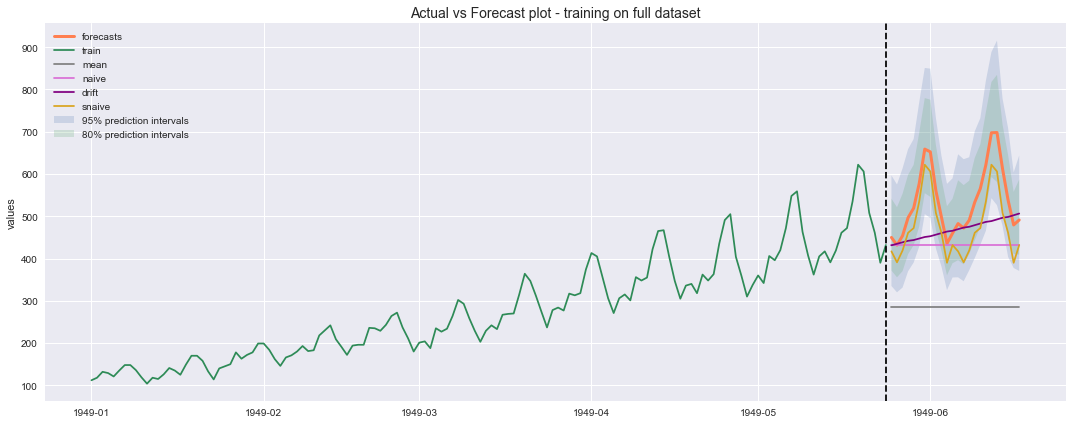

In [32]:
print("=== Plot forecasts against simple preds...")

us.plot_forecasts(
    passengers, 
    tgt_fcs_full[tgt_fcs_full > 0].fillna(0),
    full_series_index, 
    simple_preds=spreds_full,
    return_pred_int=True,
    title='Actual vs Forecast plot - training on full dataset'
)

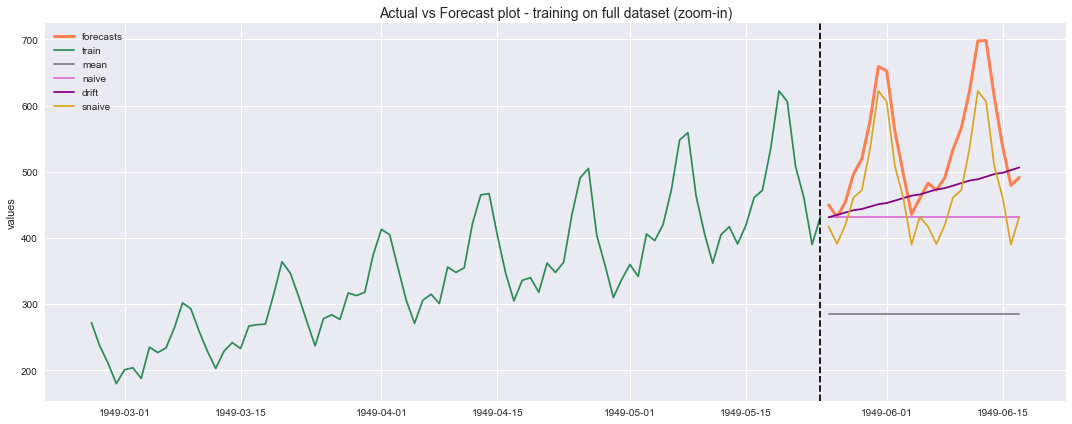

In [33]:
us.plot_forecasts(
    passengers[55:], 
    tgt_fcs_full[tgt_fcs_full > 0].fillna(0),
    full_series_index[55:], 
    simple_preds=spreds_full,
    title='Actual vs Forecast plot - training on full dataset (zoom-in)'
)

### log 2 exp

In [34]:
pass_y_log = np.log1p(passengers.values)
pass_y_log[:10]

array([4.72738782, 4.77912349, 4.89034913, 4.86753445, 4.80402104,
       4.91265489, 5.00394631, 5.00394631, 4.91998093, 4.78749174])

In [35]:
np.expm1(pass_y_log)

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [36]:
X_log, y_log = us.embed_to_X_y(
    pd.Series(pass_y_log), 
    n_lags=n_lags, name='log_passengers')

display(X_log)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18
0,5.010635,4.836282,4.912655,4.955827,4.844187,4.753590,4.779123,4.653960,4.787492,4.919981,5.003946,5.003946,4.912655,4.804021,4.867534,4.890349,4.779123,4.727388
1,5.141664,5.010635,4.836282,4.912655,4.955827,4.844187,4.753590,4.779123,4.653960,4.787492,4.919981,5.003946,5.003946,4.912655,4.804021,4.867534,4.890349,4.779123
2,5.141664,5.141664,5.010635,4.836282,4.912655,4.955827,4.844187,4.753590,4.779123,4.653960,4.787492,4.919981,5.003946,5.003946,4.912655,4.804021,4.867534,4.890349
3,5.068904,5.141664,5.141664,5.010635,4.836282,4.912655,4.955827,4.844187,4.753590,4.779123,4.653960,4.787492,4.919981,5.003946,5.003946,4.912655,4.804021,4.867534
4,4.897840,5.068904,5.141664,5.141664,5.010635,4.836282,4.912655,4.955827,4.844187,4.753590,4.779123,4.653960,4.787492,4.919981,5.003946,5.003946,4.912655,4.804021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,6.434547,6.284134,6.159095,6.135565,6.040255,5.971262,6.035481,6.006353,5.894403,6.011267,6.139885,6.327937,6.308098,6.159095,6.042633,5.983936,6.008813,5.837730
122,6.408529,6.434547,6.284134,6.159095,6.135565,6.040255,5.971262,6.035481,6.006353,5.894403,6.011267,6.139885,6.327937,6.308098,6.159095,6.042633,5.983936,6.008813
123,6.232448,6.408529,6.434547,6.284134,6.159095,6.135565,6.040255,5.971262,6.035481,6.006353,5.894403,6.011267,6.139885,6.327937,6.308098,6.159095,6.042633,5.983936
124,6.135565,6.232448,6.408529,6.434547,6.284134,6.159095,6.135565,6.040255,5.971262,6.035481,6.006353,5.894403,6.011267,6.139885,6.327937,6.308098,6.159095,6.042633


In [37]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=test_size, random_state=42, shuffle=False)

In [38]:
fasts_log = es.FASTSRegressor(
    quantile_reg=True,
    )

In [39]:
print("=== TS Randomized Search CV...")
print()

rscv_log = vd.TSRandomizedSearchCV(
    estimator=fasts_log, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

t0 = time()
rscv_log.fit(X_train_log, y_train_log)
t1 = time()

=== TS Randomized Search CV...

Best validation rmse score overall: 0.102 ± 0.043
Refitting best estimator...
X cols 18
X_sel_ cols 3
with quantile regression.
self.gbr_fitted_.n_features = 3


Full time of Search: 37.76 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.823045895483019, 5.739792912179234, 5.886104031450156, 6.003887067106539, 6.226536669287466, 6.198478716492308, 6.077642243349034, 5.8971538676367405, 5.855071922202427, 5.8944028342648505, 5.765191102784844, 5.831882477283517, 5.820082930352362, 5.723585101952381, 5.8522024797744745, 6.003887067106539, 6.148468295917647, 6.144185634125646]
length of first Lasso test window: 18
[-0.05589924484515585, -0.09378646477847319, -0.05552101702195067]
length of first GradBoost test window (residuals): 3

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 18
[-0.05589924484515585, -0.09378646477847319, -0.05552101702195067]
length of first GradBoost quantile test window (0.95): 3


You're here: 'lasso' loop...

You're here: 'grad_boost' lo

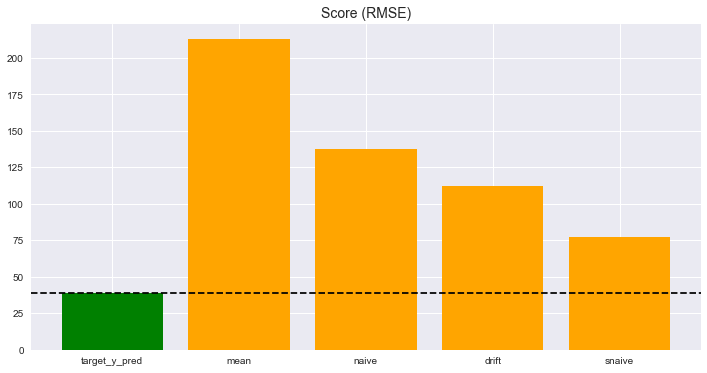

In [40]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_log = rscv_log.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_log, spreds_log, tgt_preds_log = best_fasts_log.compare_to_baselines(
    y_train_log, 
    y_test_log, 
    season=12,
    fh=fh, 
    bar_plot=True,
    bck_transformer=np.expm1
)

In [41]:
tgt_preds_log

,y_pred,low_80,up_80,low_95,up_95
0,363.569681,230.642560,572.776478,181.046440,729.094211
1,352.599301,225.625867,550.713129,177.924972,697.798299
2,384.374512,240.226583,614.659819,187.078086,788.637525
3,379.618163,240.179122,599.674658,188.266011,764.431606
4,393.040750,250.563523,616.212348,197.203132,782.378704
5,451.972068,284.586931,717.463181,222.517418,916.976308
6,504.934507,323.575711,787.628713,255.390869,997.357416
7,520.472176,333.608777,811.690071,263.343564,1027.711374
8,443.931294,276.776540,711.673057,215.273447,914.340550
9,395.241957,252.032364,619.504373,198.387013,786.451931


In [42]:
us.mean_absolute_percentage_error(
    passengers.values[-fh:],
    tgt_preds_log[tgt_preds_log > 0].fillna(0)["y_pred"])

6.393974558960864

Better than model trained/evaluated on power transformed data.


full_time_series_df
            orig_scale_posts   forecasts  y_test        mean  naive  \
Month                                                                 
1960-08-01               NaN  536.122495   606.0  252.893418  337.0   
1960-09-01               NaN  478.927997   508.0  252.893418  337.0   
1960-10-01               NaN  430.661498   461.0  252.893418  337.0   
1960-11-01               NaN  388.595551   390.0  252.893418  337.0   
1960-12-01               NaN  394.728838   432.0  252.893418  337.0   

                 drift  snaive      low_80       up_80      low_95  \
Month                                                                
1960-08-01  382.753339   505.0  345.703859  831.123921  273.764271   
1960-09-01  386.610124   404.0  303.160411  756.267791  237.713067   
1960-10-01  386.610124   359.0  271.816129  681.993523  212.799221   
1960-11-01  390.505671   310.0  247.591637  609.578437  194.805571   
1960-12-01  394.440368   337.0  255.209116  610.224596  202.3

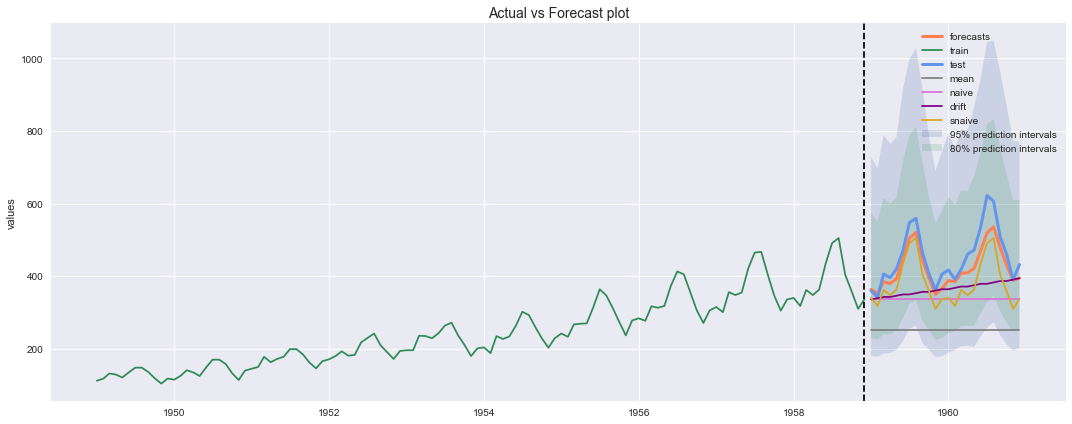

In [43]:
us.plot_forecasts(
    passengers[:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    passengers.index, 
    y_test=passengers[-fh:],
    simple_preds=spreds_log,
    return_pred_int=True)

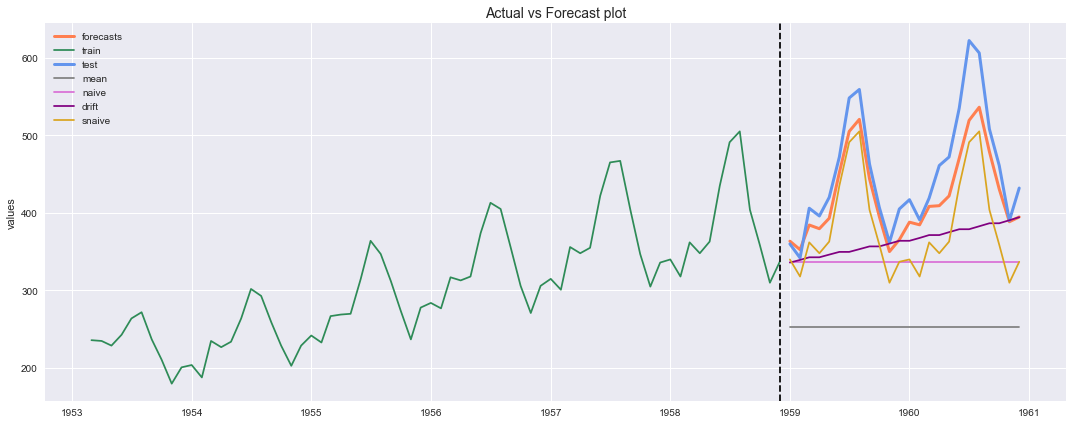

In [44]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    simple_preds=spreds_log)

Better than Box-Cox tranformation, **still underestimating** future passengers.

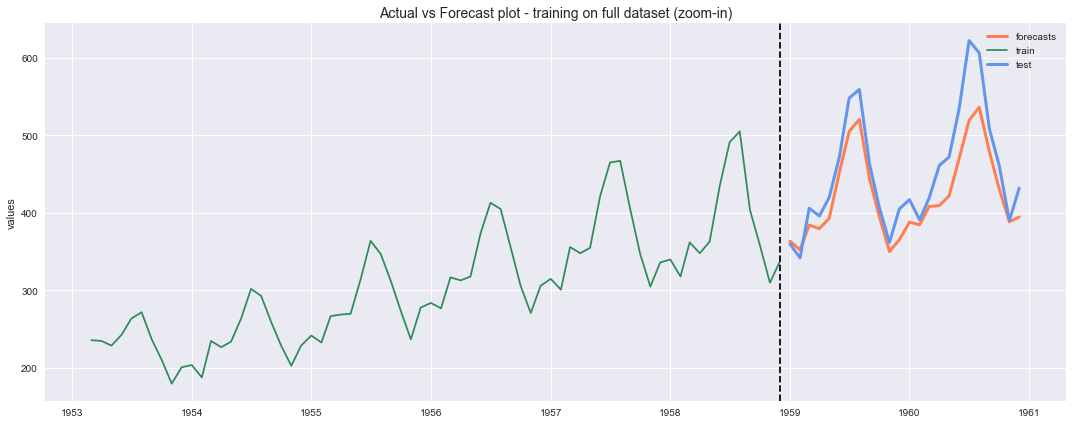

In [45]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_log[tgt_preds_log > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    title='Actual vs Forecast plot - training on full dataset (zoom-in)'
)

##### Check

In [46]:
# no cross-val.
fasts_log = es.FASTSRegressor(
    lasso_alpha=0.01,
    quantile_reg=True,
    )

In [47]:
%time fasts_log.fit(X_train_log, y_train_log)

X cols 18
X_sel_ cols 2
with quantile regression.
self.gbr_fitted_.n_features = 2
Wall time: 138 ms


FASTSRegressor(lasso_alpha=0.01, loss='quantile', quantile_reg=True)

In [48]:
tgt_preds_log_1 = fasts_log.predict(fh, pred_int=True)
tgt_preds_log_1


=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.823045895483019, 5.739792912179234, 5.886104031450156, 6.003887067106539, 6.226536669287466, 6.198478716492308, 6.077642243349034, 5.8971538676367405, 5.855071922202427, 5.8944028342648505, 5.765191102784844, 5.831882477283517, 5.820082930352362, 5.723585101952381, 5.8522024797744745, 6.003887067106539, 6.148468295917647, 6.144185634125646]
length of first Lasso test window: 18
[-0.04149772490504855, -0.06395937637882465]
length of first GradBoost test window (residuals): 2

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 18
[-0.04149772490504855, -0.06395937637882465]
length of first GradBoost quantile test window (0.95): 2


You're here: 'lasso' loop...

You're here: 'grad_boost' loop...

You're here: 'grad_boost_qtl' loop...



,y_pred,low_80,up_80,low_95,up_95
0,5.880582,5.447521,6.313642,5.217457,6.543706
1,5.834860,5.418651,6.251069,5.197540,6.472179
2,5.929037,5.477047,6.381027,5.236927,6.621147
3,5.907198,5.473749,6.340648,5.243478,6.570918
4,5.937279,5.519664,6.354895,5.297805,6.576753
5,6.076822,5.639062,6.514582,5.406502,6.747142
6,6.180404,5.753824,6.606984,5.527203,6.833605
7,6.210511,5.784112,6.636909,5.557587,6.863434
8,6.044089,5.588506,6.499672,5.346478,6.741700
9,5.940538,5.513905,6.367171,5.287257,6.593820


In [49]:
tgt_preds_1 = np.expm1(tgt_preds_log_1)
tgt_preds_1

,y_pred,low_80,up_80,low_95,up_95
0,357.017380,231.181851,551.051952,183.464577,693.856685
1,341.016815,224.574682,517.566624,179.826944,645.891989
2,374.792534,238.139523,589.534040,187.091292,749.805777
3,366.674616,237.352017,566.163748,188.327532,713.025172
4,377.902579,248.551061,574.301758,198.897607,717.203514
5,434.642600,280.198878,673.911921,221.850727,850.621520
6,482.187033,314.394306,739.247064,250.439623,927.531892
7,496.955468,324.093167,761.734112,258.196749,955.646441
8,420.613513,266.335960,663.923471,208.867782,845.999727
9,379.139488,247.118225,581.407963,196.800038,729.566239


In [50]:
us.mean_absolute_percentage_error(
    passengers.values[-fh:],
    tgt_preds_1[tgt_preds_1 > 0].fillna(0)["y_pred"])

11.057641084559672

Default model with different `alpha` does a poorer job on test data.


full_time_series_df
            orig_scale_posts   forecasts  y_test        mean  naive  \
Month                                                                 
1960-08-01               NaN  490.369758   606.0  252.893418  337.0   
1960-09-01               NaN  433.183930   508.0  252.893418  337.0   
1960-10-01               NaN  396.164748   461.0  252.893418  337.0   
1960-11-01               NaN  358.892377   390.0  252.893418  337.0   
1960-12-01               NaN  370.533407   432.0  252.893418  337.0   

                 drift  snaive      low_80       up_80      low_95       up_95  
Month                                                                           
1960-08-01  382.753339   505.0  323.038250  744.110304  258.740592  928.559132  
1960-09-01  386.610124   404.0  282.494785  663.970556  225.045293  832.973060  
1960-10-01  386.610124   359.0  256.525183  611.521986  203.580621  770.039974  
1960-11-01  390.505671   310.0  231.322095  556.512718  183.123568  702.4543

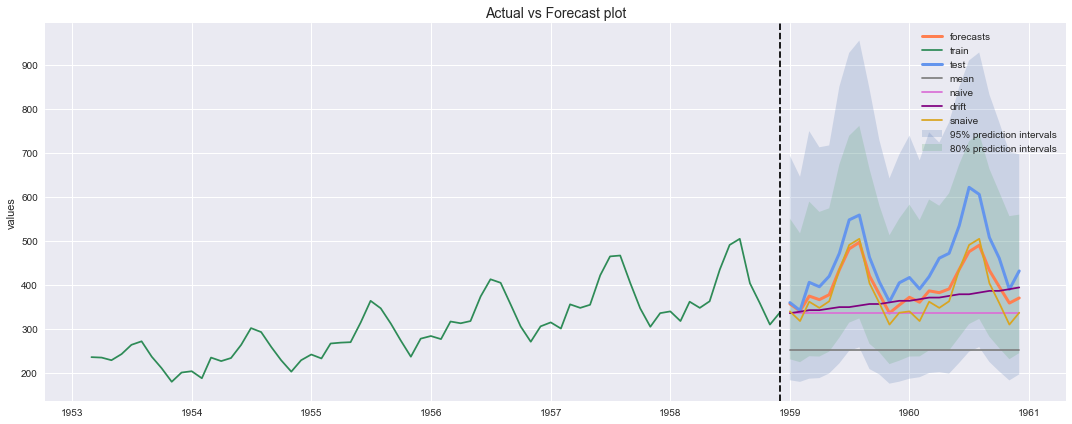

In [51]:
# 'spreds_log' from previous run
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_1[tgt_preds_1 > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    simple_preds=spreds_log,
    return_pred_int=True)

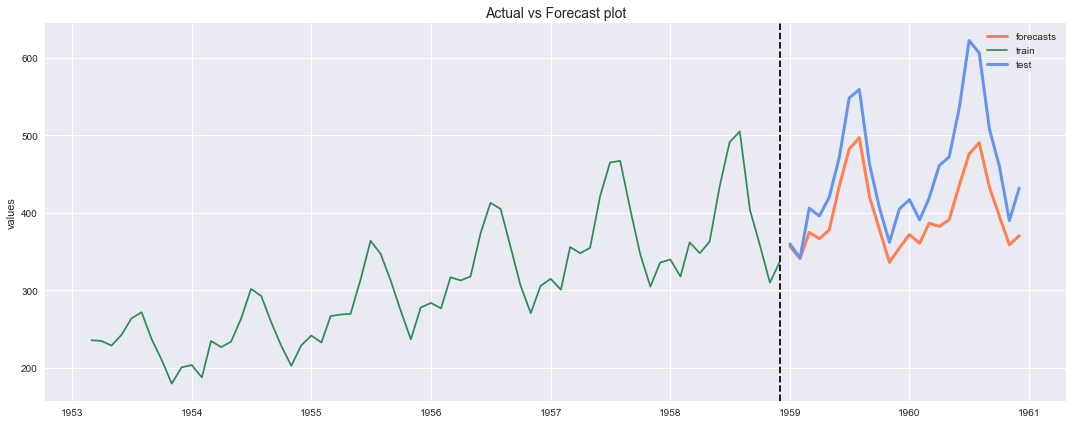

In [52]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_1[tgt_preds_1 > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:])

Despite overperforming baselines, model trained on log data heavily **underestimates** future nr of passengers, following a negative trend!

In [53]:
print("=== Fit best model upon full X_log, y_log (using best parameters from rdn search)...")

t0 = time()
best_fasts_log.fit(X_log, y_log)
t1 = time()

=== Fit best model upon full X_log, y_log (using best parameters from rdn search)...
X cols 18
X_sel_ cols 3
with quantile regression.
self.gbr_fitted_.n_features = 3


In [54]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full_log, tgt_fcs_full_log = best_fasts_log.compare_to_baselines(
    y_log, season=12, fh=fh, bck_transformer=np.expm1)

Time of fitting: 0.54 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[6.07073772800249, 5.968707559985366, 6.135564891081739, 6.2324480165505225, 6.408528791059498, 6.434546518787453, 6.284134161070802, 6.159095388491933, 6.135564891081739, 6.040254711277414, 5.971261839790462, 6.035481432524756, 6.0063531596017325, 5.8944028342648505, 6.0112671744041615, 6.139884552226255, 6.327936783729195, 6.3080984415095305]
length of first Lasso test window: 18
[-0.004581543345075545, -0.051451990026393446, 0.020253188822414003]
length of first GradBoost test window (residuals): 3

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg: 18
[-0.004581543345075545, -0.051451990026393446, 0.020253188822414003]
length of first GradBoost quantile test window (0.95): 3


You're here: 'lasso' loop...

You're here: 'grad_boost' loop...

You're he

=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts        mean  naive       drift  \
1949-06-13               NaN  667.284171  281.830097  432.0  496.701251   
1949-06-14               NaN  603.117505  281.830097  432.0  501.703232   
1949-06-15               NaN  547.805819  281.830097  432.0  506.755483   
1949-06-16               NaN  491.034223  281.830097  432.0  506.755483   
1949-06-17               NaN  502.501523  281.830097  432.0  511.858511   

            snaive      low_80       up_80      low_95       up_95  
1949-06-13   606.0  517.948866  859.592947  452.705317  983.347586  
1949-06-14   508.0  482.935001  753.146650  429.139564  847.464057  
1949-06-15   461.0  434.306159  690.898842  383.891541  781.526491  
1949-06-16   390.0  398.837736  604.489814  357.106356  675.049650  
1949-06-17   432.0  396.581730  636.639420  349.698401  721.882634  


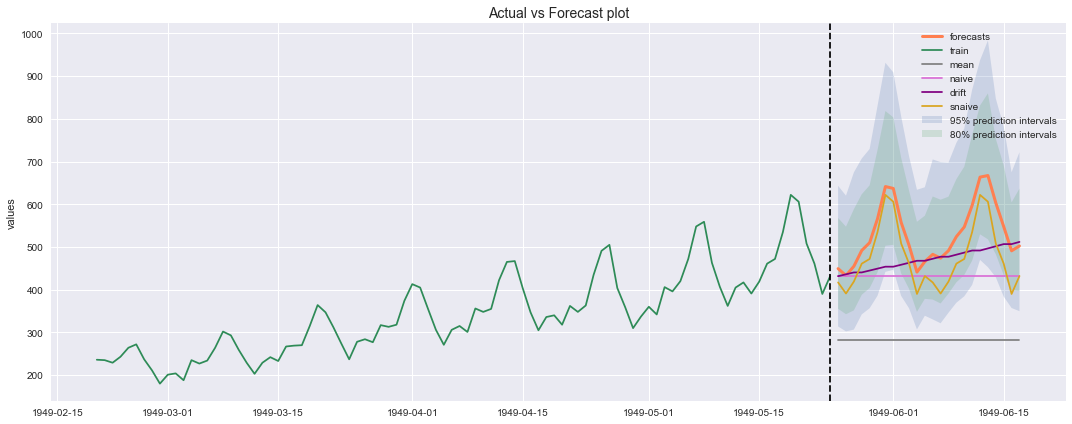

In [55]:
print("=== Plot forecasts against simple preds...")

us.plot_forecasts(
    passengers[50:], 
    tgt_fcs_full_log[tgt_fcs_full_log > 0].fillna(0),
    full_series_index[50:], 
    simple_preds=spreds_full_log,
    return_pred_int=True
)

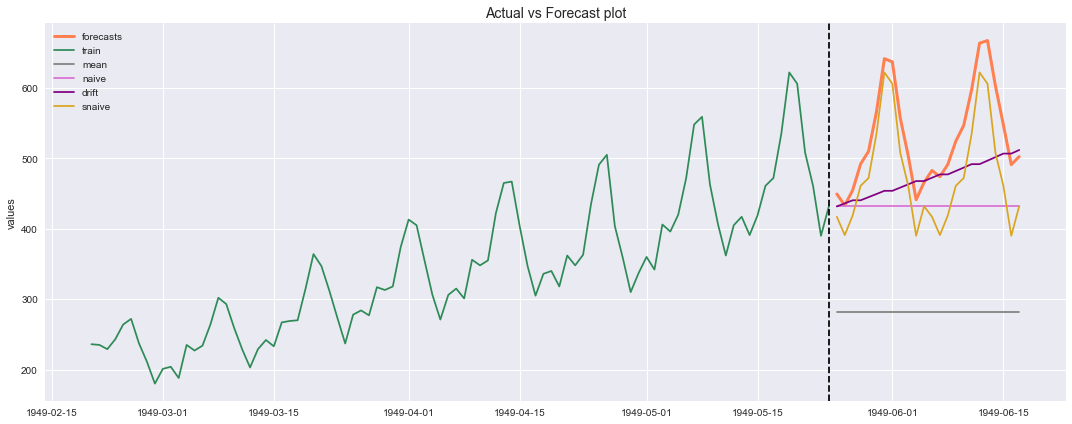

In [56]:
us.plot_forecasts(
    passengers[50:], 
    tgt_fcs_full_log[tgt_fcs_full_log > 0].fillna(0),
    full_series_index[50:], 
    simple_preds=spreds_full_log
)

Forecasts look more likely, though variance is not increasing.

### MinMax scaling

In [57]:
passengers_y_scale = scaler.fit_transform(passengers.values.reshape(-1, 1)).ravel()
passengers_y_scale[:10]

array([1.13899614, 1.24324324, 1.48648649, 1.43436293, 1.2953668 ,
       1.53861004, 1.76447876, 1.76447876, 1.55598456, 1.26061776])

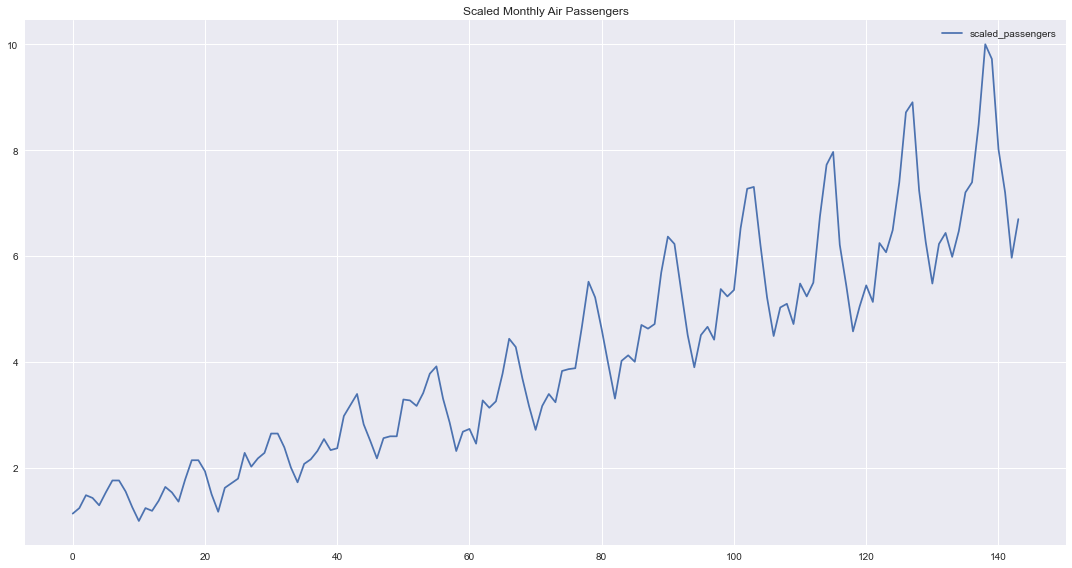

In [58]:
plt.figure(figsize=(15, 8))
plt.plot(passengers_y_scale, label="scaled_passengers")
plt.title("Scaled Monthly Air Passengers")
plt.legend()    
plt.tight_layout()

Increasing variance should not be a problem even when relying on scaled data.

In [59]:
X_sc, y_sc = us.embed_to_X_y(
    pd.Series(passengers_y_scale), 
    n_lags=n_lags, name='sscaled_passengers')

In [60]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(
    X_sc, y_sc, test_size=test_size, random_state=42, shuffle=False)

In [61]:
display(X_train_sc)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18
0,1.781853,1.364865,1.538610,1.642857,1.382239,1.191120,1.243243,1.000000,1.260618,1.555985,1.764479,1.764479,1.538610,1.295367,1.434363,1.486486,1.243243,1.138996
1,2.146718,1.781853,1.364865,1.538610,1.642857,1.382239,1.191120,1.243243,1.000000,1.260618,1.555985,1.764479,1.764479,1.538610,1.295367,1.434363,1.486486,1.243243
2,2.146718,2.146718,1.781853,1.364865,1.538610,1.642857,1.382239,1.191120,1.243243,1.000000,1.260618,1.555985,1.764479,1.764479,1.538610,1.295367,1.434363,1.486486
3,1.938224,2.146718,2.146718,1.781853,1.364865,1.538610,1.642857,1.382239,1.191120,1.243243,1.000000,1.260618,1.555985,1.764479,1.764479,1.538610,1.295367,1.434363
4,1.503861,1.938224,2.146718,2.146718,1.781853,1.364865,1.538610,1.642857,1.382239,1.191120,1.243243,1.000000,1.260618,1.555985,1.764479,1.764479,1.538610,1.295367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,7.723938,6.750965,5.500000,5.239382,5.482625,4.718147,5.100386,5.030888,4.492278,5.222008,6.212355,7.306950,7.272201,6.525097,5.361004,5.239382,5.378378,4.422780
98,7.967181,7.723938,6.750965,5.500000,5.239382,5.482625,4.718147,5.100386,5.030888,4.492278,5.222008,6.212355,7.306950,7.272201,6.525097,5.361004,5.239382,5.378378
99,6.212355,7.967181,7.723938,6.750965,5.500000,5.239382,5.482625,4.718147,5.100386,5.030888,4.492278,5.222008,6.212355,7.306950,7.272201,6.525097,5.361004,5.239382
100,5.430502,6.212355,7.967181,7.723938,6.750965,5.500000,5.239382,5.482625,4.718147,5.100386,5.030888,4.492278,5.222008,6.212355,7.306950,7.272201,6.525097,5.361004


In [62]:
fasts_sc = es.FASTSRegressor(
    quantile_reg=True,
    )

print("=== TS Randomized Search CV...")
print()

rscv_sc = vd.TSRandomizedSearchCV(
    estimator=fasts_sc, n_split=3, param_distro=fasts_params, fh=fh, 
    test_size=test_size, n_iter=n_iter, 
    n_jobs=n_jobs
)

t0 = time()
rscv_sc.fit(X_train_sc, y_train_sc)
t1 = time()

=== TS Randomized Search CV...

Best validation rmse score overall: 0.511 ± 0.192
Refitting best estimator...
X cols 18
X_sel_ cols 13
with quantile regression.
self.gbr_fitted_.n_features = 13


Full time of Search: 23.84 s

=== Compare best estimator to baselines on test data...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[5.0482625482625485, 4.579150579150579, 5.43050193050193, 6.212355212355212, 7.967181467181468, 7.723938223938224, 6.750965250965251, 5.5, 5.239382239382239, 5.482625482625482, 4.718146718146718, 5.100386100386101, 5.030888030888031, 4.492277992277993, 5.222007722007722, 6.212355212355212, 7.306949806949807, 7.2722007722007715]
length of first Lasso test window: 18
[-0.06623312326225683, -0.03229534337075446, 0.15913346433479614, -0.45468434505817523, 0.17216729522285146, 0.01650823482104702, -0.12075507495642235, -0.07818655840008937, -0.2223804646403078, -0.16293292340029186, -0.11317776132573876, -0.07522505919801414, 0.0008460496607956003]
length of first GradBoost test window (residuals): 13

... gonna predict quantiles as well.

length of first vanilla GradBoost test window befo

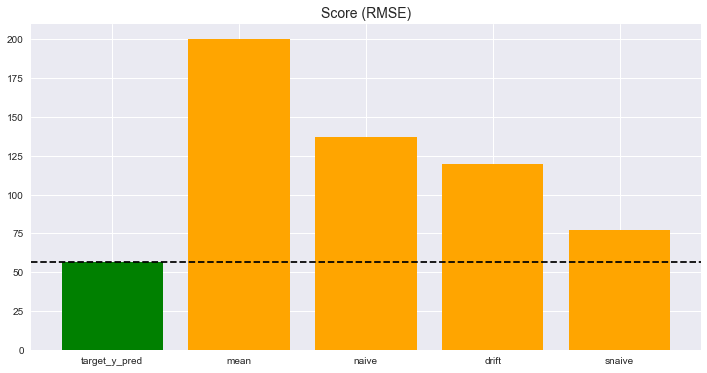

In [63]:
print(f"Full time of Search: {(t1 - t0):.2f} s")
print()

best_fasts_sc = rscv_sc.best_params_['best_estimator']

print("=== Compare best estimator to baselines on test data...")

scores_sc, spreds_sc, tgt_preds_sc = best_fasts_sc.compare_to_baselines(
    y_train_sc, 
    y_test_sc, 
    season=12,
    fh=fh, 
    bar_plot=True,
    bck_transformer=scaler
)

In [64]:
us.mean_absolute_percentage_error(
    passengers.values[-fh:],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0)["y_pred"])

11.574818099617247


full_time_series_df
            orig_scale_posts   forecasts  y_test        mean  naive  \
Month                                                                 
1960-08-01               NaN  571.410156   606.0  266.647059  337.0   
1960-09-01               NaN  455.844862   508.0  266.647059  337.0   
1960-10-01               NaN  384.498565   461.0  266.647059  337.0   
1960-11-01               NaN  337.768032   390.0  266.647059  337.0   
1960-12-01               NaN  355.784789   432.0  266.647059  337.0   

                 drift  snaive      low_80       up_80      low_95       up_95  
Month                                                                           
1960-08-01  368.180000   505.0  498.506784  644.313528  459.776868  683.043445  
1960-09-01  369.906667   404.0  379.009912  532.679812  338.191345  573.498379  
1960-10-01  371.633333   359.0  306.210990  462.786140  264.620716  504.376414  
1960-11-01  373.360000   310.0  264.209297  411.326768  225.131219  450.4048

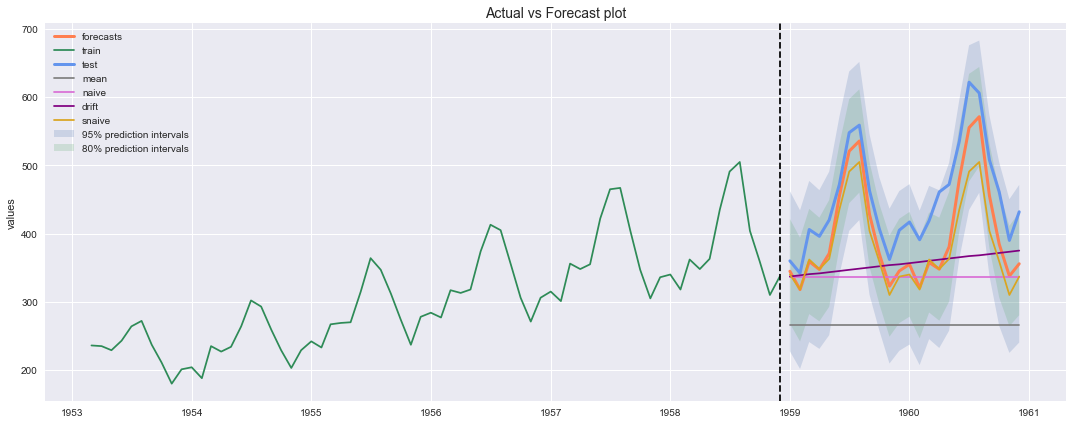

In [65]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    simple_preds=spreds_sc,
    return_pred_int=True)

Good. Prediction intervals **cover** test forecasts decently.

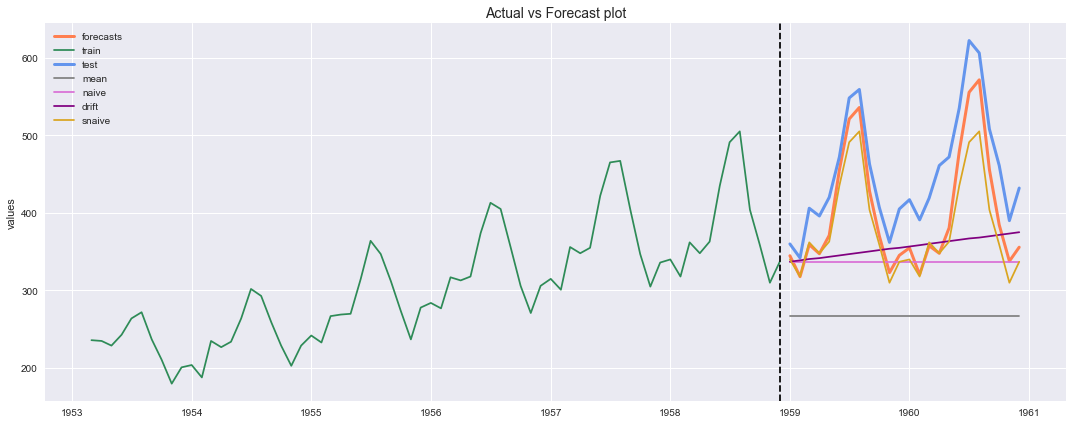

In [66]:
us.plot_forecasts(
    passengers[50:-fh],
    tgt_preds_sc[tgt_preds_sc > 0].fillna(0),
    passengers.index[50:], 
    y_test=passengers[-fh:],
    simple_preds=spreds_sc)

Again, model **underestimates** future nr of passengers :|

In [67]:
print("=== Fit best model upon full X_sc, y_sc (using best parameters from rdn search)...")

t0 = time()
best_fasts_sc.fit(X_sc, y_sc)
t1 = time()

=== Fit best model upon full X_sc, y_sc (using best parameters from rdn search)...
X cols 18
X_sel_ cols 14
with quantile regression.
self.gbr_fitted_.n_features = 14


In [68]:
print(f"Time of fitting: {(t1 - t0):.2f} s")
print()
print("=== Compare best estimator baselines...")

_, spreds_full_sc, tgt_fcs_full_sc = best_fasts_sc.compare_to_baselines(
    y_sc, season=12, fh=fh, bck_transformer=scaler)

Time of fitting: 0.46 s

=== Compare best estimator baselines...

FASTSRegressor with quantile regression performed.

=== Trying to make forecasts w FASTSRegressor...



test windows:
[6.698841698841699, 5.969111969111969, 7.202702702702703, 8.019305019305019, 9.72200772200772, 10.0, 8.48841698841699, 7.393822393822394, 7.202702702702703, 6.472972972972973, 5.986486486486487, 6.438223938223938, 6.22972972972973, 5.482625482625482, 6.264478764478764, 7.237451737451738, 8.905405405405407, 8.714285714285715]
length of first Lasso test window: 18
[-0.08923555257586724, -0.2874330805008274, 0.3431811383408485, -0.12497030111378926, -0.28828343861460937, 0.17521461757223555, 0.06693972710917073, -0.04787685407564446, 0.5017307986976958, -0.4443206449775374, -0.0909880262729299, 0.05221135850423231, 0.3715322136422312, 0.1812523290758259]
length of first GradBoost test window (residuals): 14

... gonna predict quantiles as well.

length of first vanilla GradBoost test window before quant. reg

=== Plot forecasts against simple preds...

full_time_series_df
            orig_scale_posts   forecasts   mean  naive       drift  snaive  \
1949-06-13               NaN  716.540767  302.0  432.0  471.780000   606.0   
1949-06-14               NaN  610.653632  302.0  432.0  474.082222   508.0   
1949-06-15               NaN  538.461091  302.0  432.0  475.808889   461.0   
1949-06-16               NaN  467.719745  302.0  432.0  478.111111   390.0   
1949-06-17               NaN  495.587642  302.0  432.0  480.413333   432.0   

                low_80       up_80      low_95       up_95  
1949-06-13  668.181968  764.899567  642.491355  790.590179  
1949-06-14  559.780263  661.527000  532.753786  688.553477  
1949-06-15  489.082013  587.840170  462.849377  614.072805  
1949-06-16  421.705435  513.734055  397.260333  538.179158  
1949-06-17  445.224470  545.950814  418.469035  572.706249  


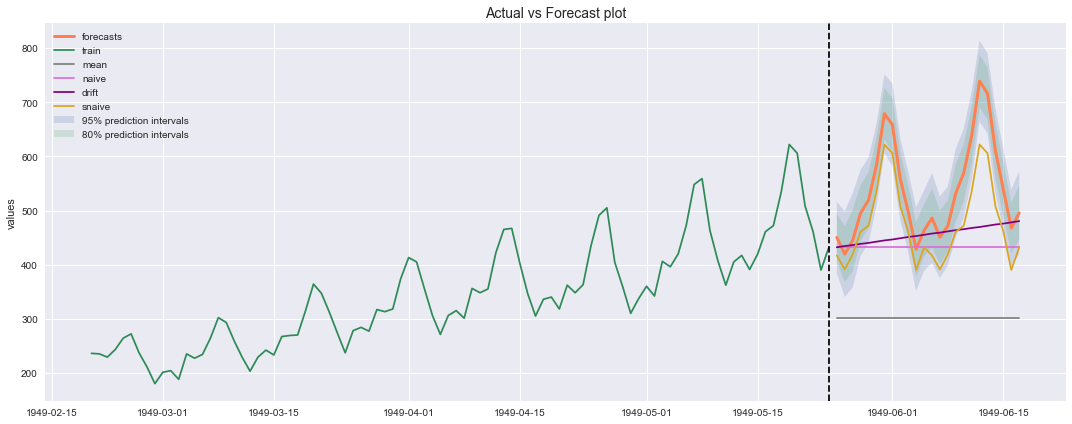

In [69]:
print("=== Plot forecasts against simple preds...")

us.plot_forecasts(
    passengers[50:], 
    tgt_fcs_full_sc[tgt_fcs_full_sc > 0].fillna(0),
    full_series_index[50:], 
    simple_preds=spreds_full_sc,
    return_pred_int=True
)

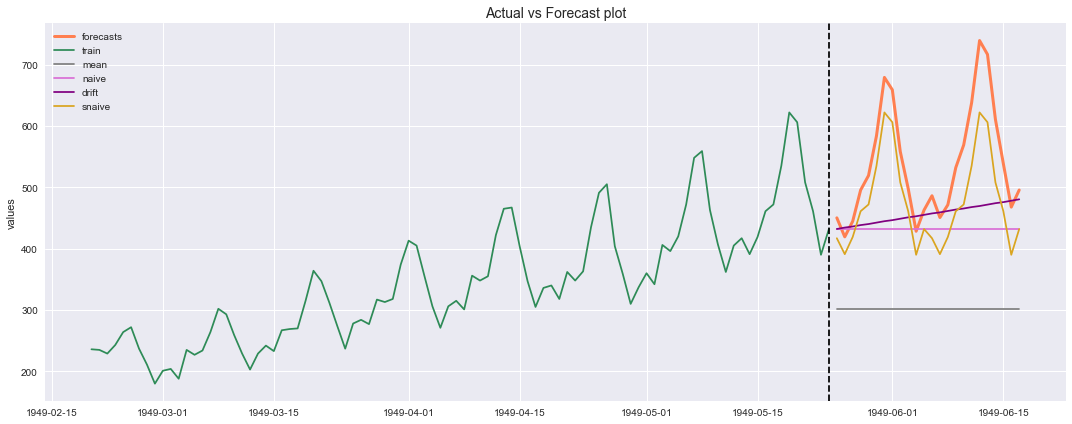

In [70]:
us.plot_forecasts(
    passengers[50:], 
    tgt_fcs_full_sc[tgt_fcs_full_sc > 0].fillna(0),
    full_series_index[50:], 
    simple_preds=spreds_full_sc,
)

At least, cyclical patterns are **matched** at every transformation / modelling.